In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/lgvaz/.fastai/data/camvid/labels'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/images'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/valid.txt')]

In [5]:
path_img = path/'images'
path_lbl = path/'labels'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/lgvaz/.fastai/data/camvid/images/0016E5_08035.png'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/images/0016E5_06240.png'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/images/0006R0_f02130.png')]

In [7]:
lbl_fnames = get_image_files(path_lbl)
lbl_fnames[:3]

[PosixPath('/home/lgvaz/.fastai/data/camvid/labels/0001TP_009000_P.png'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/labels/0001TP_010290_P.png'),
 PosixPath('/home/lgvaz/.fastai/data/camvid/labels/0016E5_01980_P.png')]

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

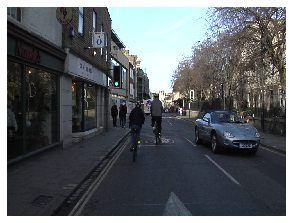

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

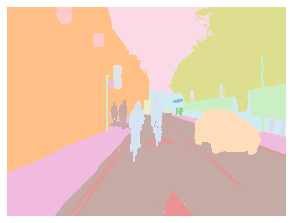

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5))

In [10]:
src_size = np.array(mask.shape[1:]); src_size

array([720, 960])

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
size = src_size//10
bs = 3
size

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

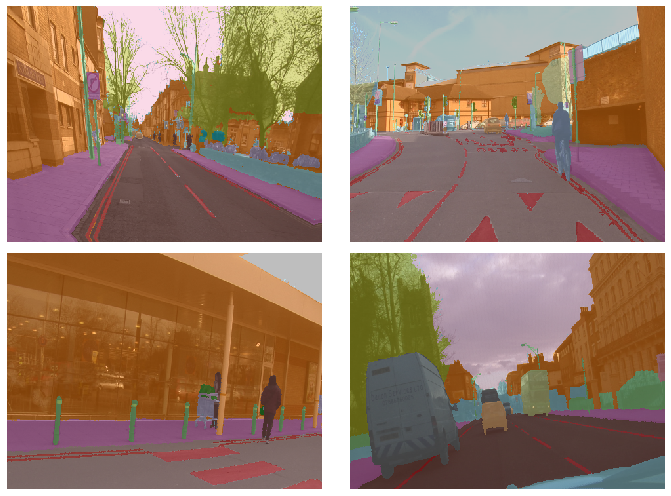

In [15]:
data.show_batch(2, figsize=(10, 7))

In [15]:
name2id = {c:i for i, c in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid).to_fp16()

In [17]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/lgvaz/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/lgvaz/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


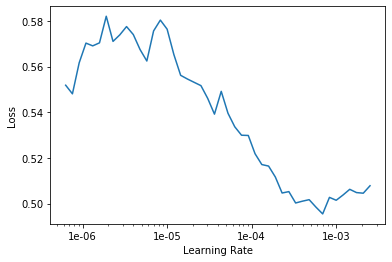

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr = 1e-4

In [20]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.393327,0.371429,0.898113,05:30
1,0.354307,0.385974,0.893358,05:18
2,0.299601,0.370958,0.904926,05:17
3,0.285082,0.324941,0.911052,05:18
4,0.266679,0.298448,0.920968,05:18
5,0.255414,0.305934,0.920156,05:24
6,0.244639,0.300045,0.918884,05:25
7,0.239738,0.294757,0.923027,05:19
8,0.228577,0.290148,0.925607,05:19
9,0.227778,0.292350,0.924324,05:22


In [21]:
learn.save('stage-1-big')

In [24]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/lgvaz/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/lgvaz/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


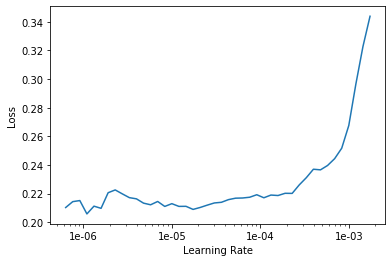

In [26]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lrs = slice(1e-6, lr/5)

In [29]:
learn.fit(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.229902,0.297781,0.919900,05:36
1,0.216535,0.258965,0.932279,05:30
2,0.216257,0.280002,0.931961,05:29
3,0.203403,0.288601,0.929851,05:30
4,0.199712,0.268471,0.929770,05:30
5,0.197262,0.265563,0.933182,05:30
6,0.196684,0.269069,0.931065,05:29
7,0.181860,0.270855,0.932812,05:30
8,0.181913,0.251974,0.935990,05:30
9,0.189564,0.260015,0.935136,05:30


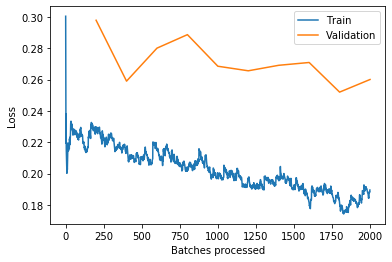

In [30]:
learn.recorder.plot_losses()

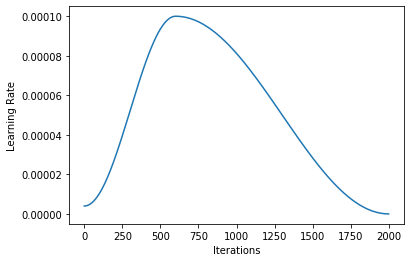

In [23]:
learn.recorder.plot_lr()

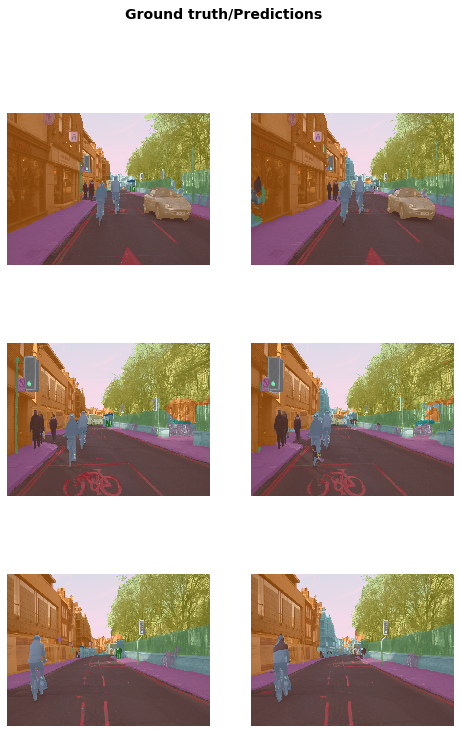

In [33]:
learn.show_results()

In [31]:
learn.save('stage-2-big')